# Evaluate our own model

In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import sys
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="5"
import shutil
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import confusion_matrix
from fastai.conv_learner import *
from fastai.model import *
from fastai.plots import *
import numpy as np

PATH = "../../datasets/boeing_vs_airbus/"
arch = resnext50

def get_file_list(directory):
    return [val for sublist in [[os.path.join(i[0], j) for j in i[2]] for i in os.walk(directory)] for val in sublist]


def get_prediction(image, learn):   
    trn_tfms, val_tfms = tfms_from_model(arch,300) # get transformations
    im = val_tfms(open_image(image))
    learn.precompute=False # We'll pass in a raw image, not activations
    preds = learn.predict_array(im[None])
    return preds


def compute_stats(cm, classes, printout=False):
    TN, FP, FN, TP = cm.ravel()
    precision = TP/(TP+FP)
    if printout: print("Precision : ", precision)
    recall = TP/(TP+FN)
    if printout: print("Recall : ", recall)
    F1 = 2 * ((precision*recall)/(precision + recall))
    if printout: print("F1 : ", F1)
    F2 = 5 * ((precision*recall)/(4*precision + recall))
    if printout: print("F2 : ", F2)

def check_prediction(classe, classes, learn):
    error = 0
    files = get_file_list(f'{PATH}valid/' + classes[classe])
    #print("Input images number : ", len(files))
    csv = ""
    for image in files:
        preds = get_prediction(image, learn)
        pred = np.argmax(preds)
        if classe != pred:
            error += 1
    print(error, "errors on", len(files), "predictions for", classe)
    return error, len(files)

In [4]:

tfms = tfms_from_model(arch, 300)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
#learn.load("resnext50_141_300_acc98.06_weights") # 3 + 4 errors
files = get_file_list(f'{PATH}'+'models')
classes = ["A380", "B747"]
best_model = ""
best_errors = 500
for file in files:
    model = file[len(f'{PATH}'+'models/'):-3]
    print("Evaluate:", model)
    try:
        learn.load(model)
        errors_B747, numbers_of_B747 = check_prediction(0, classes, learn)
        errors_A380, numbers_of_A380 = check_prediction(1, classes, learn)
        if (errors_B747 + errors_A380) < best_errors:
            best_errors = errors_B747 + errors_A380
            best_model = model
        if (errors_B747 + errors_A380) > 7:
            dest = shutil.move(file, f'{PATH}'+'models/bad/')
        cm = np.array([[numbers_of_B747-errors_B747, errors_B747],[errors_A380, numbers_of_A380-errors_A380]])
        compute_stats(cm, classes)
    except RuntimeError:
        print("WARNING : Not right size, no evaluation !")
        pass
    print("-------------------")
print("Best model : ", best_model)


Evaluate: resnext101_64_78_128_acc96.12_weights
-------------------
Evaluate: resnext5010_bestmodel
3 errors on 154 predictions for 0
2 errors on 155 predictions for 1
-------------------
Evaluate: resnext506_bestmodel
2 errors on 154 predictions for 0
2 errors on 155 predictions for 1
-------------------
Evaluate: resnext5011_bestmodel
2 errors on 154 predictions for 0
5 errors on 155 predictions for 1
-------------------
Evaluate: resnext509_bestmodel
2 errors on 154 predictions for 0
4 errors on 155 predictions for 1
-------------------
Evaluate: resnext504_bestmodel
3 errors on 154 predictions for 0
3 errors on 155 predictions for 1
-------------------
Evaluate: resnext50-13_clean_bestmodel
3 errors on 154 predictions for 0
4 errors on 155 predictions for 1
-------------------
Evaluate: resnext508_bestmodel
4 errors on 154 predictions for 0
1 errors on 155 predictions for 1
-------------------
Evaluate: resnext50_141_300_acc98.06_weights
3 errors on 154 predictions for 0
4 errors o

2 errors on 154 predictions for 0
2 errors on 155 predictions for 1
Precision :  0.987012987012987
Recall :  0.987012987012987
F1 :  0.987012987012987
F2 :  0.9870129870129869
[[152   2]
 [  2 153]]


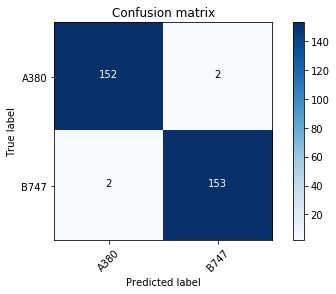

In [5]:
#best_model = 'resnext506_bestmodel'
learn.load(best_model)
errors_B747, numbers_of_B747 = check_prediction(0, classes, learn)
errors_A380, numbers_of_A380 = check_prediction(1, classes, learn)
cm = np.array([[numbers_of_B747-errors_B747, errors_B747],[errors_A380, numbers_of_A380-errors_A380]])
compute_stats(cm, classes, printout=True)
plot_confusion_matrix(cm, classes)